In [6]:
# === Standard Libraries ===
import os
import random
import yaml
import gc
import logging
import math
import subprocess
import sys

# === Data Handling ===
import pandas as pd
import numpy as np

# === Machine Learning (PyTorch) ===
import torch
import torch.nn as nn # Use nn alias consistently
from torch.optim import Adam
from torch.nn import Parameter # Keep if using custom Parameters outside nn.Module

# === Quantum Computing (PennyLane) ===
import pennylane as qml

# === Natural Language Processing ===
import spacy
import fasttext # For .bin model loading
import re #advanced data cleaning
import unidecode #advanced data cleaning

# === QNLP Libraries (DisCoPy and Lambeq) ===
import discopy
from discopy.rigid import Ty
from discopy.quantum import gates # Keep if directly using discopy gates
# from lambeq.backend.quantum import Diagram as LambeqDiagram # Usually not needed directly
from lambeq import BobcatParser, Rewriter, SpacyTokeniser, AtomicType, IQPAnsatz, StronglyEntanglingAnsatz # Pick one ansatz

# === Evaluation & Plotting ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Lambeq/DisCoPy Compatibility Patch ===
monoidal_module = getattr(discopy, "monoidal", None)
if monoidal_module:
    diagram_class = getattr(monoidal_module, "Diagram", None)
    if diagram_class and not hasattr(diagram_class, "is_mixed"):
        diagram_class.is_mixed = property(lambda self: False)
# === Load Configuration ===
try:
    with open('config.yaml', 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration loaded:\n", yaml.dump(config, indent=2))
except FileNotFoundError:
    print("Configuration file 'config.yaml' not found. Please ensure it exists in the working directory.")
    raise
except Exception as e:
    print(f"Error loading configuration: {e}")
    raise e    
# === Load SpaCy Model (using config) ===
if config:
    model_name = config['nlp']['spacy_model']
    try:
        spacy.load(model_name)
        print(f"SpaCy model {model_name} loaded.")
    except OSError:
        print(f"Downloading SpaCy model {model_name}")
        try:
            subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
            spacy.load(model_name)
            print(f"SpaCy {model_name} loaded.")
        except Exception as e:
            print(f"Failed to download SpaCy model {model_name}: {e}")
            raise e

Configuration loaded:
 data:
  fasttext_path: C:\Users\Jash\Documents\Research\Semantic Equivilance\SemanticEquivilance\cc.en.300.bin
  path: C:\Users\Jash\Documents\Research\Semantic Equivilance\SemanticEquivilance\question_pairs\questions.csv
  qubit_limit: 12
  sample_fraction: 0.05
  test_size: 0.2
  validation_size: 0.25
logging:
  log_file: error_log.txt
  log_level: WARNING
nlp:
  spacy_model: en_core_web_sm
qnlp:
  ansatz_type: StronglyEntangling
  embedding_method: parameterized
  n_layers: 2
  rewrite_rules:
  - curry
  - prepositional_phrase
  - determiner
  - coordination
  - auxiliary
simulation:
  cpu_cores: 6
  device: default.qubit
training:
  base_learning_rate: 0.001
  epochs: 5
  lambda_penalty: 0.1
  use_local_cost: true

SpaCy model en_core_web_sm loaded.


In [7]:
#Data Loading Function
def load_data(csv_file, sample_fraction=1.0):
    sentences1, sentences2, is_duplicate = [], [], []
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        if sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        
        sentences1 = df['question1'].astype(str).tolist()
        sentences2 = df['question2'].astype(str).tolist()
        is_duplicate = df['is_duplicate'].tolist()
        
        return sentences1, sentences2, is_duplicate
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], [], []

def create_balanced_training_set(training_data: list) -> list:
    """Creates a balanced training set by undersampling the majority class."""
    positives = [pair for pair in training_data if pair['label'] == 1]
    negatives = [pair for pair in training_data if pair['label'] == 0]
    
    # Undersample the larger class to match the size of the smaller class
    if len(positives) > len(negatives):
        positives = random.sample(positives, len(negatives))
    else:
        negatives = random.sample(negatives, len(positives))
    
    balanced_train_set = positives + negatives
    random.shuffle(balanced_train_set)
    
    print(f"Created a balanced training set with {len(positives)} positive and {len(negatives)} negative pairs.")
    return balanced_train_set
def load_fasttext_model(model_path: str):
    """Loads the full FastText .bin model."""
    model = fasttext.load_model(model_path)
    print("FastText model loaded successfully.")
    return model

In [8]:
#Plotting functions
def plot_training_history(history: dict):
    """Plots the training loss and the average fidelity over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss (Local Cost)')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss', linestyle=':')
        
    if 'avg_fidelity' in history and history['avg_fidelity']:
        plt.plot(history['avg_fidelity'], label='Avg. Fidelity (from SWAP Test)', linestyle='--')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_parameter_history(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return

    epochs = range(len(param_history))
    means = [d['mean'] for d in param_history]
    stds = [d['std'] for d in param_history]
    mins = [d['min'] for d in param_history]
    maxs = [d['max'] for d in param_history]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, means, label='Mean Parameter Value')
    plt.fill_between(epochs, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2, label='1 Std. Deviation')
    plt.plot(epochs, mins, linestyle='--', color='gray', label='Min/Max Range')
    plt.plot(epochs, maxs, linestyle='--', color='gray')
    
    plt.title('Evolution of Model Parameters During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_parameter_evolution_polar(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')

    epochs = np.array(range(len(param_history)))
    
    mean_angles = np.array([d['mean'] for d in param_history]) % (4 * np.pi)

    ax.plot(mean_angles, epochs, 'o-', label='Mean Parameter Path')

    if len(epochs) > 0:
        ax.plot(mean_angles[0], epochs[0], 'gX', markersize=12, label='Start')
        ax.plot(mean_angles[-1], epochs[-1], 'rX', markersize=12, label='End')

    ax.set_theta_zero_location('N')# pyright: ignore
    ax.set_theta_direction(-1)# pyright: ignore
    ax.set_rlabel_position(0)# pyright: ignore
    ax.set_rlim(0, len(epochs) * 1.05)# pyright: ignore
    ax.set_xlabel("Epoch")
    ax.set_title('Cyclical Evolution of Mean Parameter', pad=20)
    ax.legend()
    plt.show()
def plot_parameter_deltas(param_history):
    if len(param_history) < 2:
        print("Need at least 2 epochs to plot parameter deltas.")
        return

    mean_angles = np.array([d['mean'] for d in param_history])
    
    # Calculate the shortest angle difference between each epoch
    deltas = []
    for i in range(1, len(mean_angles)):
        prev_angle = mean_angles[i-1]
        curr_angle = mean_angles[i]
        delta = np.arctan2(np.sin(curr_angle - prev_angle), np.cos(curr_angle - prev_angle))
        deltas.append(delta)

    plt.figure(figsize=(10, 6))
    # We plot against epochs 1 to N, since the first delta occurs at epoch 1
    plt.plot(range(1, len(mean_angles)), deltas, 'o-', label='Change in Mean Parameter (Delta)')
    
    plt.axhline(0, color='red', linestyle='--', label='No Change')
    plt.title('Epoch-to-Epoch Change in Mean Parameter Value')
    plt.xlabel('Epoch')
    plt.ylabel('Shortest Angle Difference (Radians)')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(mean_angles)))
    plt.show()


def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    """
    Computes and plots a confusion matrix.
    
    Args:
        y_true (np.array): The ground-truth labels (0s and 1s).
        y_pred (np.array): The model's raw probability predictions (overlaps from 0 to 1).
        threshold (float): The cutoff for classifying a prediction as 1.
    """
    # Convert probability predictions to binary 0/1 predictions
    binary_preds = (y_pred >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, binary_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Duplicate', 'Predicted Duplicate'],
                yticklabels=['Actual Non-Duplicate', 'Actual Duplicate'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
def plot_roc_curve(y_true, y_pred):
    """
    Computes and plots the ROC curve and AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
# QNLP MODEL AND TRAINING PIPELINE
# Regex to find the base gate name (e.g., "Rz" from "Rz(param_name)")
gate_name_regex = re.compile(r"([A-Za-z]+)\(.*\)")

def _execute_diagram_robust(diagram, params, wires, wire_map):
    """
    Internal helper function to robustly execute diagram boxes.
    It parses gate names, maps them to QML operations, and applies parameters.
    """
    param_idx = 0
    
    for gate, offset in zip(diagram.boxes, diagram.offsets):
        
        # --- 1. Find the QML Operation ---
        op_name = gate.name
        
        # Try to parse composite names like Rz(param)
        match = gate_name_regex.match(op_name)
        if match:
            op_name = match.group(1) # e.g., "Rz"

        # --- 2. Get Wires ---
        try:
            target_wires = [wire_map[i + offset] for i in range(len(gate.dom))]
        except KeyError as e:
            print(f"  ERROR: Wire index error for gate {op_name} at offset {offset}. Wires: {list(wire_map.values())}, Error: {e}")
            continue

        # --- 3. Get Parameters ---
        gate_params = []
        num_params = len(gate.free_symbols)
        if num_params > 0:
            if param_idx + num_params > len(params):
                print(f"  ERROR: Not enough parameters provided for gate {op_name}. Need {num_params}, have {len(params) - param_idx} left.")
                continue
            gate_params = params[param_idx : param_idx + num_params]
            param_idx += num_params

        # --- 4. Apply Operation (NEW LOGIC) ---
        
        # --- THIS IS THE FIX ---
        # Catch *both* names for the entangling layer
        if op_name == 'CX' or op_name == 'CNOT':
        # --- END FIX ---
            # This is the entangling layer from StronglyEntanglingAnsatz.
            # We must manually apply the circular CNOTs.
            n_wires_in_layer = len(target_wires)
            if n_wires_in_layer < 2:
                continue # Not enough wires to entangle
            
            for i in range(n_wires_in_layer):
                # Apply CNOT from wire i to wire (i+1) % N
                control_wire = target_wires[i]
                target_wire = target_wires[(i + 1) % n_wires_in_layer]
                try:
                    qml.CNOT(wires=[control_wire, target_wire])
                except Exception as e:
                    print(f"  ERROR applying internal CNOT for '{op_name}' layer on wires {[control_wire, target_wire]}: {e}")

        elif op_name == 'H':
            op = qml.Hadamard
            try:
                op(*gate_params, wires=target_wires)
            except Exception as e:
                print(f"  ERROR applying op {op_name} with {len(gate_params)} params to wires {target_wires}: {e}")

        elif hasattr(qml, op_name):
            # Handles Rz, Rx, Ry, CZ, etc.
            op = getattr(qml, op_name)
            try:
                op(*gate_params, wires=target_wires)
            except Exception as e:
                print(f"  ERROR applying op {op_name} with {len(gate_params)} params to wires {target_wires}: {e}")
        
        else:
            # Skip things that aren't gates (like Ket, Bra, Measure, 0, 1, sqrt(2), etc.)
            continue

def execute_discopy_diagram(current_width, diagram, params, wires, embedding_method='simple_pad', rotation_param=None, entangling_param=None):
    """Executes a DisCoPy/lambeq diagram's instructions, including padding (Robust version)."""
    wire_map = {i: w for i, w in enumerate(wires)}
    
    # Execute the actual diagram gates
    _execute_diagram_robust(diagram, params, wires, wire_map)
    
    # --- Apply trainable padding (ancilla operations) ---
    # This logic remains the same as your original
    ancilla_wires = wires[current_width:]
    if embedding_method == 'parameterized':
        if rotation_param is not None:
            for w in ancilla_wires: qml.RY(rotation_param, wires=w)
        if entangling_param is not None and len(ancilla_wires) > 1:
            for i in range(len(ancilla_wires)):
                # --- FIX: Use ControlledPhaseShift instead of CPHASE ---
                qml.ControlledPhaseShift(entangling_param, wires=[ancilla_wires[i], ancilla_wires[(i + 1) % len(ancilla_wires)]])

def execute_discopy_diagram_local(diagram, params, wires):
    """Executes a DisCoPy/lambeq diagram without padding for local measurements (Robust version)."""
    wire_map = {i: w for i, w in enumerate(wires)}
    
    # Execute the actual diagram gates
    _execute_diagram_robust(diagram, params, wires, wire_map)
def get_diagram_width(diagram):
    """Calculates the true maximum width of a diagram at any point."""
    if not diagram.boxes:
        return len(diagram.cod)
    # The width is the maximum wire index a box acts on.
    return max(
        [offset + len(box.dom) for box, offset in zip(diagram.boxes, diagram.offsets)]
        + [len(diagram.cod)]
    )
    
def normalize_text(text):
    """Transliterates special characters and keeps only the first sentence."""
    text = unidecode.unidecode(text) # Replaces smart quotes, etc.
    text = re.sub(r'[%\\\\/]', ' ', text) # Replace problematic characters
    
    # --- NEW FIX ---
    # Split the text by sentence-ending punctuation (? or .)
    # and take only the first sentence.
    first_sentence = re.split(r'[?.]', text, maxsplit=1)[0]
    
    # Add back the punctuation if it was a question
    if '?' in text:
        return first_sentence + '?'
    else:
        return first_sentence + '.'
    # --- END NEW FIX ---

def preprocess_data_for_model(data_pairs, Tokeniser, ansatz, parser, rewriter, qubit_limit=20):
    """
    Uses lambeq pipeline, logs errors, doesn't retry on failures.
    """
    print(f"Starting preprocessing with qubit limit {qubit_limit}...")
    filtered_pairs, all_symbols, n_max = [], set(), 0
    N = AtomicType.NOUN

    for i, (s1, s2, is_duplicate) in enumerate(data_pairs):
        try:
            # Pipeline: parse, rewrite, ansatz
            d1 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(normalize_text(s1)), tokenised=True)))
            d2 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(normalize_text(s2)), tokenised=True)))
            
            width1 = get_diagram_width(d1)
            width2 = get_diagram_width(d2)

            if width1 <= qubit_limit and width2 <= qubit_limit:
                pair_data = {'s1': s1, 's2': s2, 'label': is_duplicate, 'd1': d1, 'd2': d2,
                             'structural_disparity': abs(width1 - width2),
                             'width1': width1, 'width2': width2}
                filtered_pairs.append(pair_data)
                all_symbols.update(d1.free_symbols)
                all_symbols.update(d2.free_symbols)
                n_max = max(n_max, width1, width2)

        except Exception as e:
            logging.exception(f"Error processing pair #{i+1}: Sentences: {s1} /// {s2}: {e}")
            continue # Skip this pair

    print(f"Preprocessing complete. Found {len(filtered_pairs)} valid pairs.")
    print(f"Total unique parameters (symbols) found: {len(all_symbols)}")
    print(f"N_Max for the filtered dataset is: {n_max}")
    return filtered_pairs, sorted(list(all_symbols), key=lambda s: s.name), n_max

class QNLPModel(nn.Module):
    """Generates the exact number of parameters required by the diagram."""
    def __init__(self, symbols, embedding_dim=300, max_params_heuristic=100):
        super().__init__()
        # We need a way to map the averaged sentence vector to a variable number of params.
        # Let's use a simple MLP instead of just Linear. Kharti's method
        # Outputting a large fixed size, we will slice later if needed, but based on symbols count.
        # Max possible symbols could be large, let's estimate or find max_symbols needed across dataset.
        # For now, let's assume a reasonable max (e.g., 50 parameters typical?)
        # A better approach might be needed if this max is too small or too large.
        max_params_heuristic = 50 # Adjust as needed
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Linear(embedding_dim // 2, max_params_heuristic)
        )
        self.symbol_to_word = {s.name.replace('.', '_'): s.name.split('_')[-1] for s in symbols}
        #trainable padding parameters
        self.rotation_param = Parameter(torch.rand(1)*0.01)
        self.entangling_param = Parameter(torch.rand(1)*0.01)
        
    def forward(self, diagram, fasttext_model):
        symbols = diagram.free_symbols
        num_required_params = len(symbols)
        
        if not symbols or num_required_params == 0:
            return torch.tensor([]) # Return empty tensor if no params needed

        words = [self.symbol_to_word.get(s.name.replace('.', '_')) for s in symbols]
        vectors = [fasttext_model.get_word_vector(w) for w in words if w]
        
        if not vectors:
            # If no words found, return zeros matching required params
            return torch.zeros(num_required_params)

        sentence_vector = torch.tensor(vectors, dtype=torch.float32).mean(dim=0)
        
        # Generate a large fixed set of potential parameters
        all_params = self.encoder(sentence_vector)
        
        # Slice exactly the number needed for this diagram
        if num_required_params > all_params.shape[0]:
             # Handle cases needing more params than our heuristic max
             # This might indicate the heuristic needs increasing or a different strategy
             logging.warning(f"Diagram requires {num_required_params} params, but model only outputs {all_params.shape[0]}. Truncating.")
             return all_params # Or handle error appropriately
        
        quantum_params = all_params[:num_required_params]
        return quantum_params

# === FULL REPLACEMENT for train_model function in Cell 5 ===

def train_model(model, fasttext_model, training_data, validation_data, n_max, device_name,
                base_learning_rate, lambda_penalty, epochs, embedding_method):
    """
    Trains the QNLP model using a local cosine similarity cost function,
    includes validation, logs SWAP test fidelity, and parameter history.
    """
    optimizer = Adam(model.parameters(), lr=base_learning_rate)
    
    # Define devices
    dev = qml.device(device_name, wires=n_max)
    swap_dev = qml.device(device_name, wires=1 + 2 * n_max) # Device for SWAP test

    # --- QNodes ---
    # QNode for local expectation values (returns a list of tensors)
    @qml.qnode(dev, interface="torch", diff_method="parameter-shift") # Ensure backprop diff method
    def local_expval_qnode(params, diagram, num_qubits):
        """Executes diagram locally and returns list of expectation values."""
        execute_discopy_diagram_local(diagram, params, wires=range(num_qubits))
        if num_qubits == 0:
             return [] # Return empty list if no qubits
        exp_vals = [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]
        return exp_vals # Return Python list of tensors (check is expected value)

    # QNode for SWAP test (for logging fidelity)
    @qml.qnode(swap_dev, interface="torch") # diff_method not strictly needed here as it's under no_grad
    def swap_test_qnode(p1, p2, theta, phi, w1, d1, w2, d2):
        """Performs SWAP test between two diagram executions."""
        qml.Hadamard(wires=0)
        # Execute diagram 1 on wires 1 to n_max
        execute_discopy_diagram(w1, d1, p1, range(1, 1 + n_max), embedding_method, theta, phi)
        # Execute diagram 2 on wires n_max+1 to 2*n_max
        execute_discopy_diagram(w2, d2, p2, range(1 + n_max, 1 + 2 * n_max), embedding_method, theta, phi)
        # Apply controlled SWAPs
        for j in range(n_max):
            qml.CSWAP(wires=[0, 1 + j, 1 + n_max + j])
        qml.Hadamard(wires=0)
        return qml.expval(qml.PauliZ(0)) # Measures overlap (fidelity)

    # --- Helper Function for Loss ---
    def calculate_loss(exp_vals1_tensor, exp_vals2_tensor, label, n_max):
        """Calculates cosine similarity based loss after padding."""
        # Pad tensors to n_max length
        pad_size1 = n_max - exp_vals1_tensor.shape[0]
        pad_size2 = n_max - exp_vals2_tensor.shape[0]
        if pad_size1 > 0: exp_vals1_tensor = torch.nn.functional.pad(exp_vals1_tensor, (0, pad_size1), 'constant', 0.0)
        if pad_size2 > 0: exp_vals2_tensor = torch.nn.functional.pad(exp_vals2_tensor, (0, pad_size2), 'constant', 0.0)

        # Calculate Cosine Similarity (add batch dim, compute, remove batch dim)
        epsilon = 1e-8
        cosine_sim = torch.nn.functional.cosine_similarity(
            exp_vals1_tensor.unsqueeze(0),
            exp_vals2_tensor.unsqueeze(0),
            dim=1,
            eps=epsilon
        ).squeeze(0) # Result is a single scalar tensor

        # Map similarity from [-1, 1] to [0, 1]
        predicted_similarity = (cosine_sim + 1.0) / 2.0

        # Ensure target is float and on the same device
        target_similarity = torch.tensor(float(label), dtype=predicted_similarity.dtype, device=predicted_similarity.device)

        # Mean Squared Error loss
        local_loss = (predicted_similarity - target_similarity)**2
        return local_loss

    # --- Training Setup ---
    history = {'train_loss': [], 'val_loss': [], 'avg_fidelity': [], 'param_history': []}
    print("--- Starting training with COSINE SIMILARITY (local) cost function ---")

    # --- Epoch Loop ---
    for epoch in range(epochs):
        
        # === TRAINING PHASE ===
        model.train() # Set model to training mode
        total_train_loss = 0.0
        total_fidelity = 0.0
        num_trained_pairs = 0

        for i, pair in enumerate(training_data):
            optimizer.zero_grad() # Reset gradients for this pair

            # 1. Get parameters from classical model
            params1 = model(pair['d1'], fasttext_model)
            params2 = model(pair['d2'], fasttext_model)

            # Skip if either diagram needs no parameters (likely edge case/error)
            if params1.nelement() == 0 or params2.nelement() == 0:
                print(f"Skipping training pair {i} - no parameters needed.")
                continue

            # 2. Execute QNodes to get expectation value lists
            list_exp_vals1 = local_expval_qnode(params1, pair['d1'], pair['width1'])
            list_exp_vals2 = local_expval_qnode(params2, pair['d2'], pair['width2'])

            # Check if QNode output is empty (shouldn't happen if params existed)
            if not list_exp_vals1 or not list_exp_vals2:
                 print(f"Skipping training pair {i} - empty QNode output.")
                 continue

            # 3. Stack the lists into tensors *outside* the QNode
            exp_vals1_tensor = torch.stack(list_exp_vals1)
            exp_vals2_tensor = torch.stack(list_exp_vals2)
            
            # 4. Calculate Loss
            local_loss = calculate_loss(exp_vals1_tensor, exp_vals2_tensor, pair['label'], n_max)

            # 5. Add structural penalty (as float, doesn't break grad chain)
            structural_penalty = lambda_penalty * pair['structural_disparity']
            loss = local_loss + structural_penalty

            # 6. Backpropagation
            try:
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                num_trained_pairs += 1
            except RuntimeError as e:
                print(f"ERROR during backprop/step on pair {i}: {e}")
                print(f"  Loss requires_grad: {loss.requires_grad}, grad_fn: {loss.grad_fn}")
                # Optional: Print grad status of params if error occurs
                # for name, p in model.named_parameters():
                #     if p.requires_grad: print(f"    {name}: grad is None? {p.grad is None}")
                continue # Skip to next pair if backprop fails

            # 7. Log Fidelity (no gradients needed)
            with torch.no_grad():
                fidelity = swap_test_qnode(
                    params1, params2,
                    model.rotation_param, model.entangling_param, # Pass trainable padding params
                    pair['width1'], pair['d1'],
                    pair['width2'], pair['d2']
                )
                total_fidelity += fidelity.item()

        # --- End of Training Loop for Epoch ---
        avg_train_loss = total_train_loss / num_trained_pairs if num_trained_pairs > 0 else 0.0
        avg_fidelity = total_fidelity / num_trained_pairs if num_trained_pairs > 0 else 0.0
        history['train_loss'].append(avg_train_loss)
        history['avg_fidelity'].append(avg_fidelity)

        # === VALIDATION PHASE ===
        model.eval() # Set model to evaluation mode
        total_val_loss = 0.0
        num_val_pairs = 0

        with torch.no_grad(): # Ensure no gradients are computed
            for pair in validation_data:
                # 1. Get parameters
                params1 = model(pair['d1'], fasttext_model)
                params2 = model(pair['d2'], fasttext_model)
                if params1.nelement() == 0 or params2.nelement() == 0: continue

                # 2. Execute QNodes
                list_exp_vals1_val = local_expval_qnode(params1, pair['d1'], pair['width1'])
                list_exp_vals2_val = local_expval_qnode(params2, pair['d2'], pair['width2'])
                if not list_exp_vals1_val or not list_exp_vals2_val: continue
                # --- ADD THIS DEBUG BLOCK ---
                print(f"  Pair {i} - list_exp_vals1[0] requires_grad: {list_exp_vals1[0].requires_grad if list_exp_vals1 else 'Empty'}, grad_fn: {list_exp_vals1[0].grad_fn if list_exp_vals1 else 'Empty'}")
                # --- END DEBUG BLOCK ---

                # 3. Stack
                exp_vals1_val_tensor = torch.stack(list_exp_vals1_val)
                exp_vals2_val_tensor = torch.stack(list_exp_vals2_val)

                # 4. Calculate Loss (only local part for validation)
                local_loss_val = calculate_loss(exp_vals1_val_tensor, exp_vals2_val_tensor, pair['label'], n_max)

                total_val_loss += local_loss_val.item()
                num_val_pairs += 1

        # --- End of Validation Loop for Epoch ---
        avg_val_loss = total_val_loss / num_val_pairs if num_val_pairs > 0 else 0.0
        history['val_loss'].append(avg_val_loss)

        # === Log Parameter Statistics ===
        current_epoch_params = []
        with torch.no_grad():
             for p in model.parameters():
                  if p.requires_grad: # Only log trainable parameters
                       current_epoch_params.append(p.data.flatten().cpu()) # Move to CPU
        if current_epoch_params:
             all_params_np = torch.cat(current_epoch_params).numpy()
             if all_params_np.size > 0:
                  history['param_history'].append({
                       'mean': np.mean(all_params_np),
                       'std': np.std(all_params_np),
                       'min': np.min(all_params_np),
                       'max': np.max(all_params_np)
                  })

        # --- Print Epoch Summary ---
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Avg Fidelity: {avg_fidelity:.4f}")

    # --- End of All Epochs ---
    print("--- Training finished ---")
    return model, history

def evaluate_model(model, fasttext_model, test_data, n_max, device_name, embedding_method):
    """Evaluates the trained model on the test set using the SWAP test."""
    print("\n--- Starting Evaluation on Test Set ---")
    model.eval()
    swap_dev = qml.device(device_name, wires=1 + 2 * n_max)
    predictions, true_labels = [], []
    @qml.qnode(swap_dev, interface="torch")
    def swap_test_qnode(p1, p2, theta, phi, w1, d1, w2, d2):
        qml.Hadamard(wires=0)
        execute_discopy_diagram(w1, d1, p1, range(1, 1 + n_max), embedding_method, theta, phi)
        execute_discopy_diagram(w2, d2, p2, range(1 + n_max, 1 + 2 * n_max), embedding_method, theta, phi)
        for j in range(n_max): qml.CSWAP(wires=[0, 1 + j, 1 + n_max + j])
        qml.Hadamard(wires=0)
        return qml.expval(qml.PauliZ(0))
    with torch.no_grad():
        for pair in test_data:
            params1 = model(pair['d1'], fasttext_model)
            params2 = model(pair['d2'], fasttext_model)
            measured_overlap = swap_test_qnode(params1, params2, model.rotation_param, model.entangling_param, pair['width1'], pair['d1'], pair['width2'], pair['d2'])
            predictions.append(measured_overlap.item())
            true_labels.append(pair['label'])
    
    if predictions:
        # Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
        threshold = 0.5
        binary_preds = (np.array(predictions) >= threshold).astype(int)
        true_labels_arr = np.array(true_labels)

        # ✅ Calculate F1 Score
        f1 = f1_score(true_labels_arr, binary_preds)
        print(f"Test Set F1 Score: {f1:.4f}")

        # You can also calculate accuracy here if desired
        accuracy = np.mean(binary_preds == true_labels_arr)
        print(f"Test Set Accuracy: {accuracy:.4f}")

        print("\n--- Evaluation Plots ---")
        plot_confusion_matrix(true_labels_arr, np.array(predictions), threshold=threshold) # Pass true_labels_arr
        plot_roc_curve(true_labels_arr, np.array(predictions)) # Pass true_labels_arr
    else:
        print("No valid pairs in the test set to evaluate.")

Error logging initialized. Errors will ONLY be logged to error_log.txt.
Initialized Lambeq components with STRONGLYENTANGLING ansatz.
FastText model loaded successfully.
Total loaded data pairs: 20218
Starting preprocessing with qubit limit 12...
Preprocessing complete. Found 641 valid pairs.
Total unique parameters (symbols) found: 7623
N_Max for the filtered dataset is: 12
Preprocessing finished. Filtered pairs: 641
Created a balanced training set with 144 positive and 144 negative pairs.

Data split using test_size=0.2, validation_size=0.25
288 train, 128 val, 129 test pairs.
--- Starting training with COSINE SIMILARITY (local) cost function ---
ERROR during backprop/step on pair 0: element 0 of tensors does not require grad and does not have a grad_fn
  Loss requires_grad: False, grad_fn: None
ERROR during backprop/step on pair 1: element 0 of tensors does not require grad and does not have a grad_fn
  Loss requires_grad: False, grad_fn: None
ERROR during backprop/step on pair 2: e

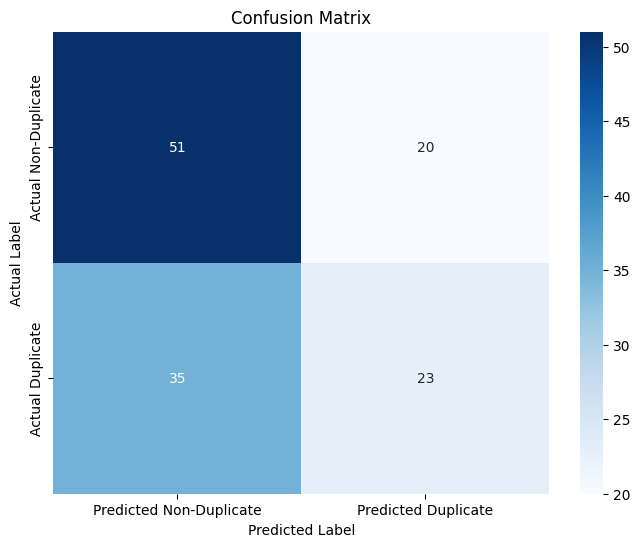

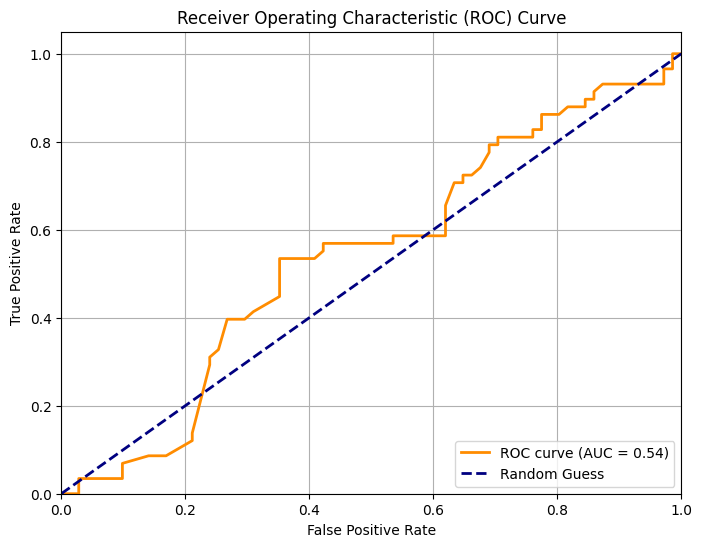

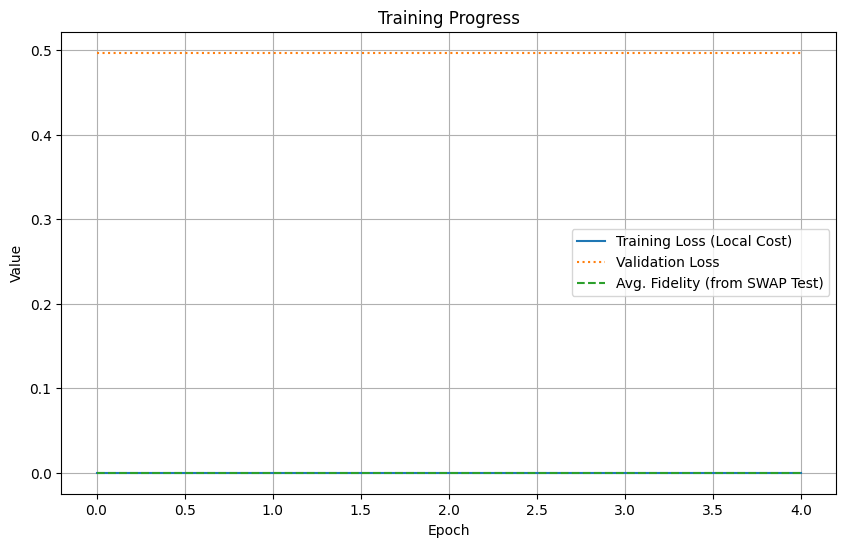

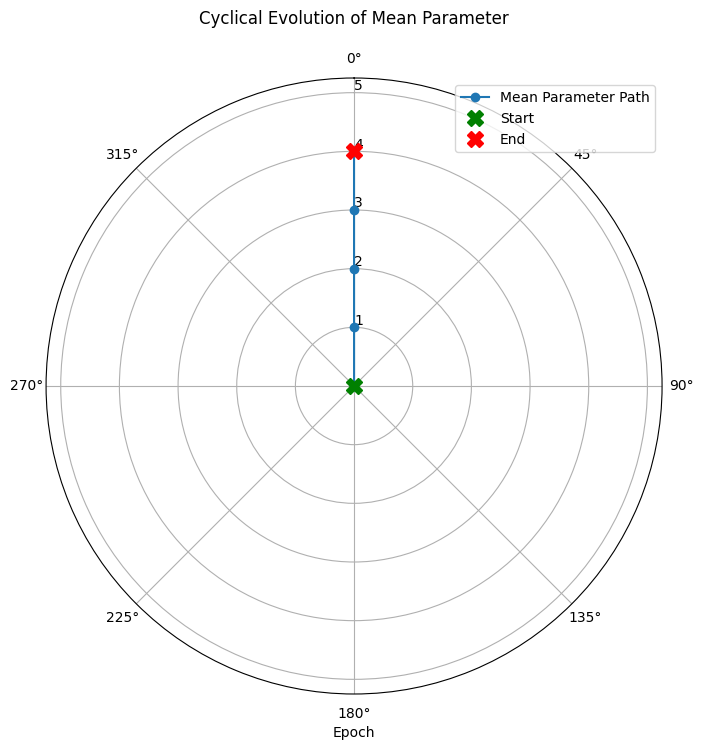

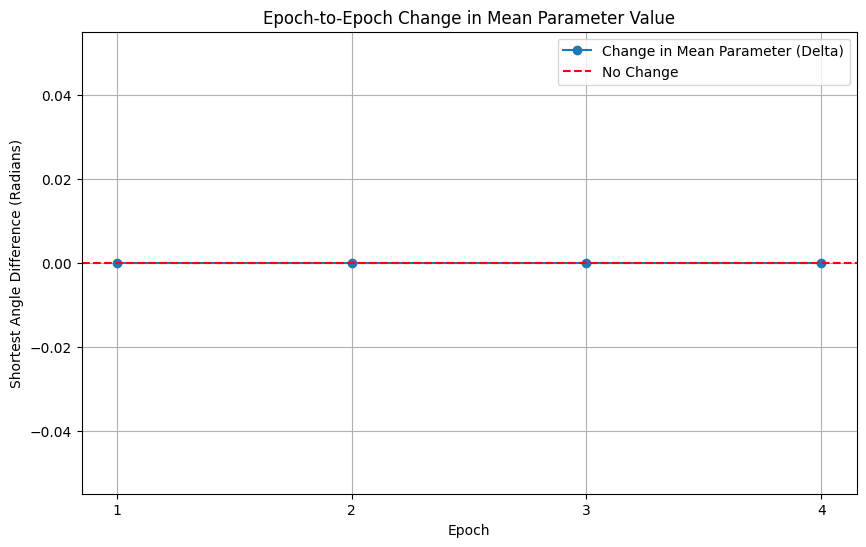

In [10]:
#Click this to run model
def main(config_path: str):
    """Main function to run the entire workflow."""
    
    # --- Error logging ---
    log_file = config['logging']['log_file']
    log_level_str = config['logging']['log_level'].upper()
    log_level = getattr(logging, log_level_str, logging.WARNING)
    
    # Get root logger and clear default handlers
    logger = logging.getLogger()
    logger.setLevel(log_level)
    if logger.hasHandlers():
        logger.handlers.clear()
    # Create custom file handler
    file_handler = logging.FileHandler(log_file, mode='w', encoding='utf-8')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - Func: %(funcName)s - Line: %(lineno)d - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    print(f"Error logging initialized. Errors will ONLY be logged to {log_file}.")
    # --- End of Logging Setup ---

    # --- Initialize Lambeq Objects ---
    tokeniser = SpacyTokeniser()
    parser = BobcatParser()
    rewriter = Rewriter(config['qnlp']['rewrite_rules'])
    N = AtomicType.NOUN; S = AtomicType.SENTENCE; P=AtomicType.PREPOSITIONAL_PHRASE; C=AtomicType.CONJUNCTION
    ansatz_type = config['qnlp'].get('ansatz_type', 'IQP').upper()
    if ansatz_type == 'STRONGLYENTANGLING':
        ansatz = StronglyEntanglingAnsatz({N: 1, S: 1, P:1, C:0}, n_layers=config['qnlp']['n_layers'])
    else:
        ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=config['qnlp']['n_layers'])
    print(f"Initialized Lambeq components with {ansatz_type} ansatz.")
    
    # --- Load Data and Models ---
    fasttext_model = load_fasttext_model(config['data']['fasttext_path'])
    if not fasttext_model: return
    
    sentences1, sentences2, value = load_data(config['data']['path'], config['data']['sample_fraction'])
    data_pairs = list(zip(sentences1, sentences2, value))
    print(f"Total loaded data pairs: {len(data_pairs)}")
    gc.collect() # Clean up memory after loading raw data
    
    # --- Preprocess Data ---
    filtered_data, symbols, n_max = preprocess_data_for_model(
        data_pairs, tokeniser, ansatz, parser, rewriter, config['data']['qubit_limit']
    )
    del data_pairs, sentences1, sentences2, value; gc.collect() # Clean up memory after preprocessing
    print(f"Preprocessing finished. Filtered pairs: {len(filtered_data)}")
    
    if filtered_data and n_max > 0:
        # --- Create Datasets ---
        val_size_fraction = config['data'].get('validation_size', 0.25)
        train_val_data_raw, test_data = train_test_split(filtered_data, test_size=config['data']['test_size'], random_state=42)
        train_data_raw, val_data = train_test_split(train_val_data_raw, test_size=val_size_fraction, random_state=42) # Use validation_size
        training_data = create_balanced_training_set(train_data_raw)
        print(f"\nData split using test_size={config['data']['test_size']}, validation_size={val_size_fraction}")
        print(f"{len(training_data)} train, {len(val_data)} val, {len(test_data)} test pairs.")
        del train_val_data_raw; del train_data_raw; gc.collect() # Clean up memory after splitting data
        
        # --- Initialize Model and Train ---
        embedding_dim = fasttext_model.get_dimension()
        model = QNLPModel(symbols, embedding_dim=embedding_dim)
        use_local_cost = config['training'].get('use_local_cost', True)
        
        if use_local_cost:
            trained_model, history = train_model(
            model=model, fasttext_model=fasttext_model, training_data=training_data,
            validation_data=val_data, n_max=n_max, device_name=config['simulation']['device'],
            base_learning_rate=config['training']['base_learning_rate'],
            lambda_penalty=config['training']['lambda_penalty'], epochs=config['training']['epochs'],
             embedding_method=config['qnlp']['embedding_method']
        )
        else:
            #swap test cost fx
            print("Only local cost function training is implemented in this script.")
            return NotImplemented
        gc.collect() # Clean up memory after training
        
        # --- Evaluate and Plot ---
        evaluate_model(
            model=trained_model, fasttext_model=fasttext_model, test_data=test_data,
            n_max=n_max, device_name=config['simulation']['device'],
            embedding_method=config['qnlp']['embedding_method']
        )
        plot_training_history(history)
        if 'param_history' in history and history['param_history']:
            plot_parameter_evolution_polar(history['param_history'])
            plot_parameter_deltas(history['param_history'])
    else:
        print("\nNo data to train on.")

# Call main
config_file_path = 'config.yaml'
main(config_file_path)